In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import data_preprocessing as dp
import PCA.pca_utilities as pu

In [2]:
data, events = dp.load_data(subjects=range(1,11))
data, events = dp.choose_condition(data, events, 'inner speech')

### Paramters

In [3]:
train_size = 0.8
test_size = 0.1
valid_size = 0.1
explained_var = 0.98

### Functions:
 - plot original and reconstructed pca data
 - plot PCA
 - Plot difference between original and PCA reconstruction


In [4]:
def side_by_side(original, reconstructed, indexes):
    org = original[indexes]
    rec = reconstructed[indexes]
    middle = np.zeros((org.shape[0],20))
    pair = np.concatenate((org, middle), axis=1)
    pair = np.concatenate((pair, rec), axis=1)
    plt.figure(figsize=(16,14))
    plt.imshow(pair, cmap='viridis')
    plt.title('Before and after pca')
    plt.show()

In [5]:
def pca_pic(pca_data, index, dim = 1):
    plt.figure(figsize= (8 ,6))
    if dim != 1:
        plt.imshow(pca_data[index])
    else:
        plt.plot(pca_data[index])
    plt.title('PCA data')
    plt.show()

In [6]:
def difference(original, reconstructed, indexes):
    org = original[indexes]
    rec = reconstructed[indexes]
    diff = org-rec
    plt.figure(figsize=(8,7))
    plt.imshow(diff)
    plt.title('Difference: Before- after')
    plt.show()

In [7]:
def split_dataset(ds, split_proportions = {
    'train': 0.8,
    'valid': 0.1,
    'test': 0.1}):
  assert sum(split_proportions.values()) <= 1,\
      "The sum of split_proportions is larger than 1!"
  ds_len = len(list(ds))
  split_dataset = {}
  start = 0
  for key, value in split_proportions.items():
    samples = int(ds_len*value)
    split_dataset[key] = ds[start:start+samples]
    start +=samples
  return split_dataset


### Data preparation:
filter relevant interval


In [8]:
f_data = dp.filter_interval(data, [1,3.5],256)

Standardize

In [9]:
#standardize data
scaler = StandardScaler()
s_data = scaler.fit_transform(f_data.reshape(-1, f_data.shape[-1])).reshape(f_data.shape)

### Create PCA datasets

In [10]:
# reshape version
rf_data = s_data.reshape(len(s_data), 128*640)
rf_split = split_dataset(rf_data)
# mean version
split = split_dataset(s_data)
mean_data = np.mean(split['train'], axis = 0)

### Fit and apply PCA:
Fit and apply on reshaped data

In [11]:
# fit and apply on reshaped data
pca_1 = PCA(n_components=explained_var)
rf_pca = pca_1.fit(rf_split['train'])
rf_pca_ds = {}
for key in rf_split:
    rf_pca_ds[key] = pca_1.transform(rf_split[key])



Shape before PCA:  (1660, 81920)
Shape after PCA:  (1660, 1319)


Text(0.5, 1.0, 'PCA on reshaped EEG data')

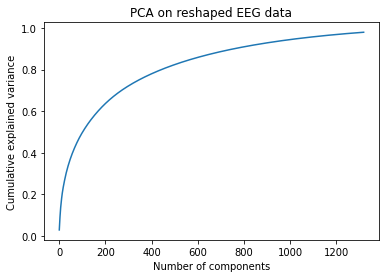

In [12]:
# print shapes before and after pca
print("Shape before PCA: ", rf_split['train'].shape)
print("Shape after PCA: ", rf_pca_ds['train'].shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA on reshaped EEG data")

In [13]:
# reverse pca
inv_rf_pca = pca_1.inverse_transform(rf_pca_ds['train'])
inv_rf = [scaler.inverse_transform(elem.reshape(128, 640)) for elem in inv_rf_pca]

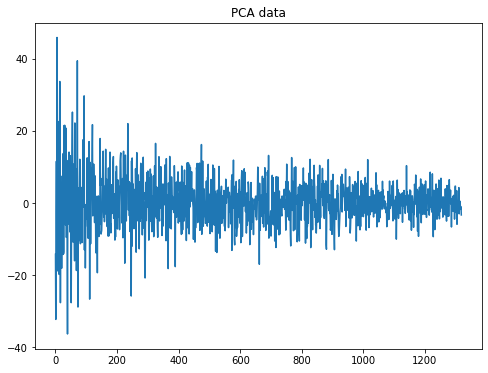

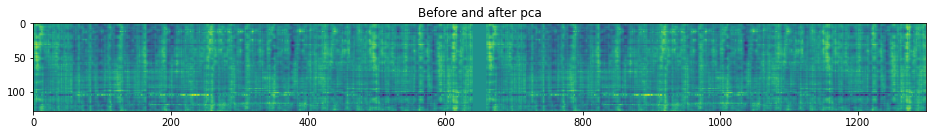

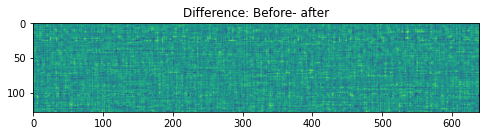

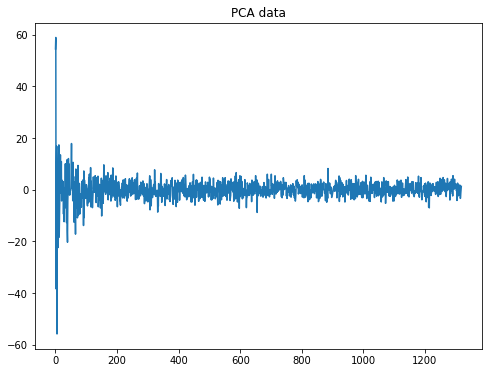

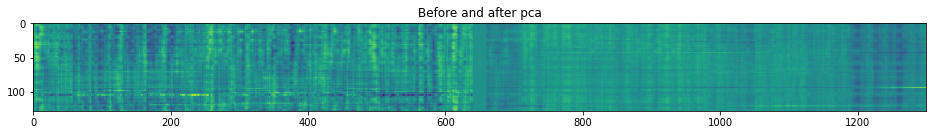

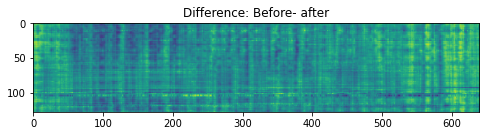

In [14]:
# plot results
for elem in range(1):
    pu.pca_pic(rf_pca_ds['train'], elem)
    pu.side_by_side(f_data, inv_rf,elem)
    pu.difference(f_data, inv_rf,elem)


fit on mean data, applied on time dimension

In [15]:
# fit on mean data, applied on time dimension
pca_2 = PCA(n_components=explained_var)
pca_2.fit(mean_data)
mean_time_pca = {}
for key in split:
    mean_time_pca[key] = [pca_2.transform(elem) for elem in split[key]]


Shape before PCA:  (128, 640)
Shape after PCA:  (128, 39)


Text(0.5, 1.0, 'PCA based on mean EEG data for time dimension')

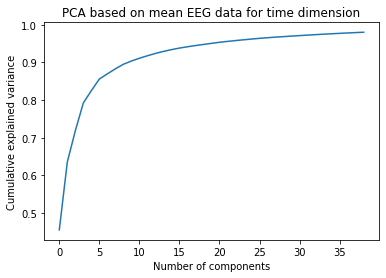

In [16]:
# print shapes before and after pca
print("Shape before PCA: ", mean_data.shape)
print("Shape after PCA: ", mean_time_pca['train'][0].shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA based on mean EEG data for time dimension")

In [17]:
# reverse pca
inv_mean_time_pca = [pca_2.inverse_transform(elem) for elem in mean_time_pca['train']]
inv_mean_time= [scaler.inverse_transform(elem) for elem in inv_mean_time_pca]
inv_mean_time_pca_valid = [pca_2.inverse_transform(elem) for elem in mean_time_pca['valid']]
inv_mean_time_valid= [scaler.inverse_transform(elem) for elem in inv_mean_time_pca_valid]

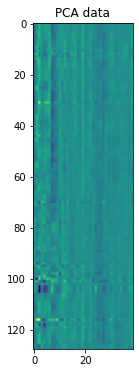

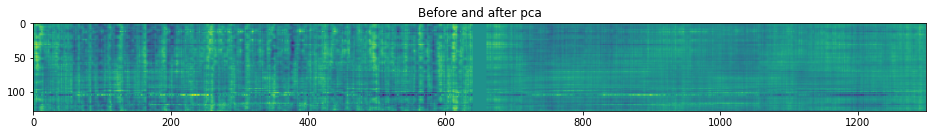

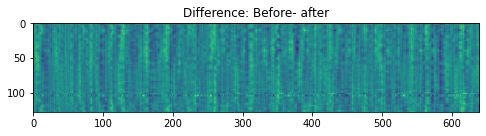

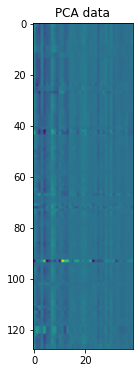

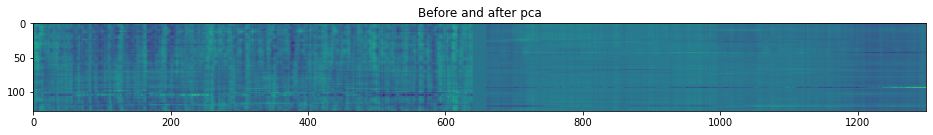

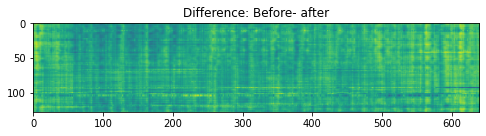

In [18]:
# plot results
for elem in range(1):
    pca_pic(mean_time_pca['train'], elem, dim = 2)
    side_by_side(f_data, inv_mean_time,elem)
    difference(f_data, inv_mean_time,elem)
    pca_pic(mean_time_pca['valid'], elem, dim = 2)
    side_by_side(f_data, inv_mean_time_valid,elem)
    difference(f_data, inv_mean_time_valid,elem)

fit on transposed mean data, applied on channel dimension

In [19]:
# fit on transposed mean data, applied on channel dimension
pca_3 = PCA(n_components=explained_var)
pca_3.fit(mean_data.T)
mean_channel_pca = {}
for key in split:
    mean_channel_pca[key] = [pca_3.transform(elem.T).T for elem in split[key]]



Shape before PCA:  (128, 640)
Shape after PCA:  (46, 640)


Text(0.5, 1.0, 'PCA on reshaped EEG data for channel dimension')

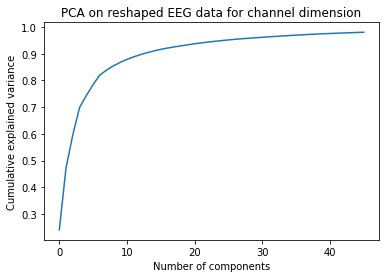

In [20]:
# print shapes before and after pca
print("Shape before PCA: ", mean_data.shape)
print("Shape after PCA: ", mean_channel_pca['train'][0].shape)

# plot explained variance by n components
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("PCA on reshaped EEG data for channel dimension")

In [21]:
# reverse pca
inv_mean_channel_pca = [pca_3.inverse_transform(elem.T).T for elem in mean_channel_pca['train']]
inv_mean_channel= [scaler.inverse_transform(elem) for elem in inv_mean_channel_pca]
inv_mean_channel_pca_valid = [pca_3.inverse_transform(elem.T).T for elem in mean_channel_pca['valid']]
inv_mean_channel_valid= [scaler.inverse_transform(elem) for elem in inv_mean_channel_pca_valid]

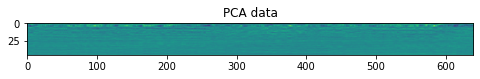

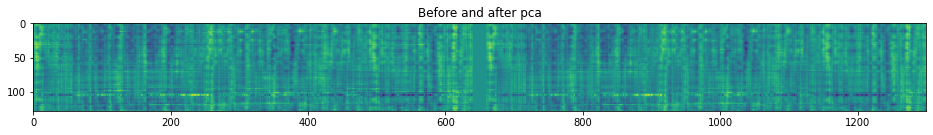

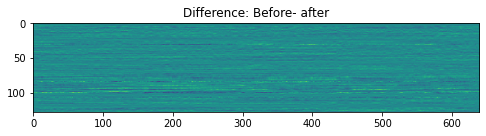

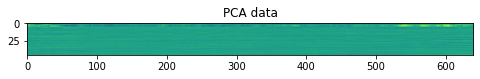

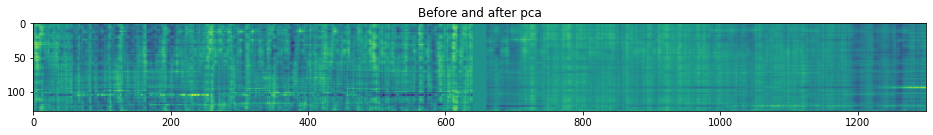

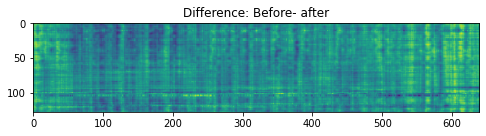

In [22]:
# plot results
for elem in range(1):
    pca_pic(mean_channel_pca['train'], elem, dim = 2)
    side_by_side(f_data, inv_mean_channel,elem)
    difference(f_data, inv_mean_channel,elem)

    pca_pic(mean_channel_pca['valid'], elem, dim = 2)
    side_by_side(f_data, inv_mean_channel_valid,elem)
    difference(f_data, inv_mean_channel_valid,elem)